# Imports

In [1]:
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_VISIBLE_DEVICES=1


In [2]:
import os
import torch
import matplotlib.pyplot as plt

In [3]:
import matplotlib
matplotlib.rcParams['figure.facecolor'] = 'white'

In [4]:
DEVICE = torch.device('cuda')

In [5]:
%run ../utils/__init__.py
%run ../datasets/__init__.py
%run ../models/checkpoint/__init__.py
%run ../utils/nlp.py

# Load data

In [6]:
kwargs = {
    'dataset_name': 'cxr14', # iu-x-ray
    'dataset_type': 'all',
    'batch_size': 25,
    'image_format': 'L',
    'frontal_only': True,
    'norm_by_sample': True,
    'image_size': (1024, 1024),
}

dataloader = prepare_data_classification(**kwargs)
len(dataloader.dataset)

112120

# Load model

In [7]:
run_name = '1202_015907_jsrt_scan_lr0.0005_normS_size1024_wce1-6-3-3_aug10_sch-iou-p5-f0.5'
debug = False

In [8]:
compiled_model = load_compiled_model_segmentation(run_name, debug=debug, device=DEVICE)
compiled_model.metadata

{'model_kwargs': {'model_name': 'scan', 'n_classes': 4},
 'opt_kwargs': {'lr': 0.0005},
 'lr_sch_kwargs': {'mode': 'max',
  'threshold_mode': 'abs',
  'factor': 0.5,
  'patience': 5,
  'verbose': True},
 'hparams': {'loss_weights': [0.1, 0.6, 0.3, 0.3],
  'early_stopping': True,
  'early_stopping_kwargs': {'patience': 20, 'metric': 'iou', 'min_delta': 0},
  'lr_sch_metric': 'iou'},
 'dataset_kwargs': {'dataset_name': 'jsrt',
  'batch_size': 20,
  'image_size': [1024, 1024],
  'num_workers': 2,
  'norm_by_sample': True},
 'dataset_train_kwargs': {'shuffle': None,
  'augment': True,
  'augment_label': None,
  'augment_class': None,
  'augment_times': 10,
  'augment_kwargs': {'crop': 0.8,
   'translate': 0.1,
   'rotation': 15,
   'contrast': 0.8,
   'brightness': 0.8,
   'shear': [10, 10]}},
 'run_name': '1202_015907_jsrt_scan_lr0.0005_normS_size1024_wce1-6-3-3_aug10_sch-iou-p5-f0.5'}

# Segment images

And save masks

In [9]:
from PIL import Image
from tqdm.notebook import tqdm

In [28]:
%run ../utils/shapes.py

In [10]:
def calculate_output(batch):
    images = batch.image.to(DEVICE)

    with torch.no_grad():
        outputs = compiled_model.model(images).detach().cpu()
        # shape: batch_size, n_labels, height, width

    _, outputs = outputs.max(dim=1)
    # shape: batch_size, height, width

    return outputs

In [13]:
def assertions(mask):
    min_value = mask.min()
    assert min_value == 0, f'Minimum must be zero, got {min_value}'
    
    max_value = mask.max()
    assert max_value == 3, f'Maximum must be three, got {min_value}'

In [14]:
def get_filepath(masks_folder, image_name):
    filepath = os.path.join(masks_folder, image_name)
    if not filepath.endswith('.png'):
        filepath += '.png'
    return filepath

In [22]:
VERSION = 'v1'

In [23]:
masks_folder = os.path.join(dataloader.dataset.dataset_dir, 'masks', VERSION)
if os.path.isdir(masks_folder):
    raise Exception('Previous masks are being overriden!')
os.makedirs(masks_folder, exist_ok=True)

In [44]:
state = tqdm(total=len(dataloader.dataset))

for batch in dataloader:
    outputs = calculate_output(batch).cpu()
    
    for image_name, mask in zip(batch.image_fname, outputs):
        mask = mask.to(torch.uint8).numpy()
        # shape: height, width
        
        assertions(mask)
        
        # Keep only largest shape:
        polygons = calculate_polygons(mask)
        largest_polygons = get_largest_shapes(polygons)
        mask = polygons_to_array(largest_polygons, mask.shape)

        assertions(mask)

        mask = Image.fromarray(mask, mode='L')
        fpath = get_filepath(masks_folder, image_name)
        
        if os.path.isfile(fpath):
            raise Exception('Overriding previous mask!')
        mask.save(fpath)

        state.update(1)

  0%|          | 0/112120 [00:00<?, ?it/s]

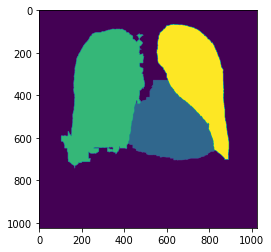

In [45]:
plt.imshow(mask)

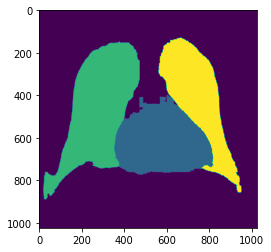

In [37]:
plt.imshow(mask)

# Debug load dataset

In [46]:
%run ../utils/common.py

In [ ]:
%run ../datasets/iu_xray.py

dataset = IUXRayDataset('all', image_size=(1024, 1024), frontal_only=True, masks=True)
len(dataset)

In [47]:
%run ../datasets/cxr14.py

dataset = CXR14Dataset('all', image_size=(1024, 1024), frontal_only=True,
                       masks=True, masks_version='v1')
len(dataset)

112120

In [48]:
def squeeze_masks(masks):
    n_dim = len(item.masks.size())
    if n_dim == 2:
        return masks
    
    n_organs = item.masks.size(0)
    multiplier = torch.arange(0, n_organs).unsqueeze(-1).unsqueeze(-1)
    return (multiplier * item.masks).sum(dim=0)

In [52]:
item = dataset[1]
item.image.size(), item.masks.size(), item.image_fname

(torch.Size([3, 1024, 1024]), torch.Size([4, 1024, 1024]), '00000001_001.png')

(-0.5, 1023.5, 1023.5, -0.5)

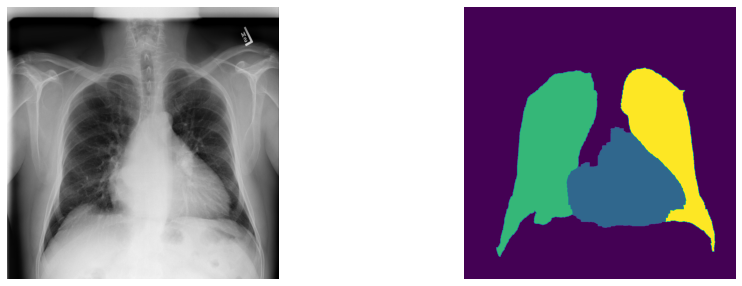

In [53]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.imshow(tensor_to_range01(item.image).permute(1, 2, 0))
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(squeeze_masks(item.masks))
plt.axis('off')